In [13]:
import pandas as pd
from prophet import Prophet
from prophet.plot import plot_plotly, plot_components_plotly
from prophet.diagnostics import performance_metrics
from prophet.plot import plot_cross_validation_metric
from prophet.serialize import model_to_json, model_from_json
from prophet.diagnostics import cross_validation

In [14]:
sao_goncalo_data = pd.read_csv("data/data.csv")

sao_goncalo_data = sao_goncalo_data[sao_goncalo_data['Rio'] != 'lagoa dos patos']

sao_goncalo_data['ds'] = pd.to_datetime(sao_goncalo_data['ds'],format="%d/%m/%Y %H:%M:%S")

#sao_goncalo_data['ds'] = sao_goncalo_data['ds'].dt.strftime("%d/%m/%Y %H:%M:%S")

In [15]:
sao_goncalo_data.tail()

,ds,Rio,y
280,2024-05-19 14:00:00,sao goncalo,2.99
283,2024-05-19 16:00:00,sao goncalo,3.00
285,2024-05-19 19:00:00,sao goncalo,2.98
287,2024-05-19 20:00:00,sao goncalo,2.97
289,2024-05-19 21:00:00,sao goncalo,2.95


In [16]:
pos_wind = pd.read_csv("data/wind.csv")

pos_wind['ds'] = pd.to_datetime(pos_wind['ds'], format="%d/%m/%Y %H:%M:%S")

#pos_wind['ds'] = pos_wind['ds'].dt.strftime("%d/%m/%Y %H:%M:%S")

sao_goncalo_data = pd.merge(sao_goncalo_data, pos_wind, on="ds")

In [17]:
pos_wind.head()

,ds,pos_wind
0,2024-05-04 14:00:00,126
1,2024-05-04 20:00:00,82
2,2024-05-05 15:00:00,112
3,2024-05-05 20:00:00,82
4,2024-05-06 09:00:00,45


In [18]:
sao_goncalo_data.tail(50)

,ds,Rio,y,pos_wind
138,2024-05-16 22:00:00,sao goncalo,3.00,260
139,2024-05-16 23:00:00,sao goncalo,3.00,260
140,2024-05-17 00:00:00,sao goncalo,2.99,260
141,2024-05-17 01:00:00,sao goncalo,2.98,250
142,2024-05-17 02:00:00,sao goncalo,2.98,250
143,2024-05-17 03:00:00,sao goncalo,2.98,250
144,2024-05-17 04:00:00,sao goncalo,2.97,250
145,2024-05-17 05:00:00,sao goncalo,2.97,250
146,2024-05-17 08:00:00,sao goncalo,2.95,270
147,2024-05-17 09:00:00,sao goncalo,2.94,270


22:07:44 - cmdstanpy - INFO - Chain [1] start processing
22:07:44 - cmdstanpy - INFO - Chain [1] done processing


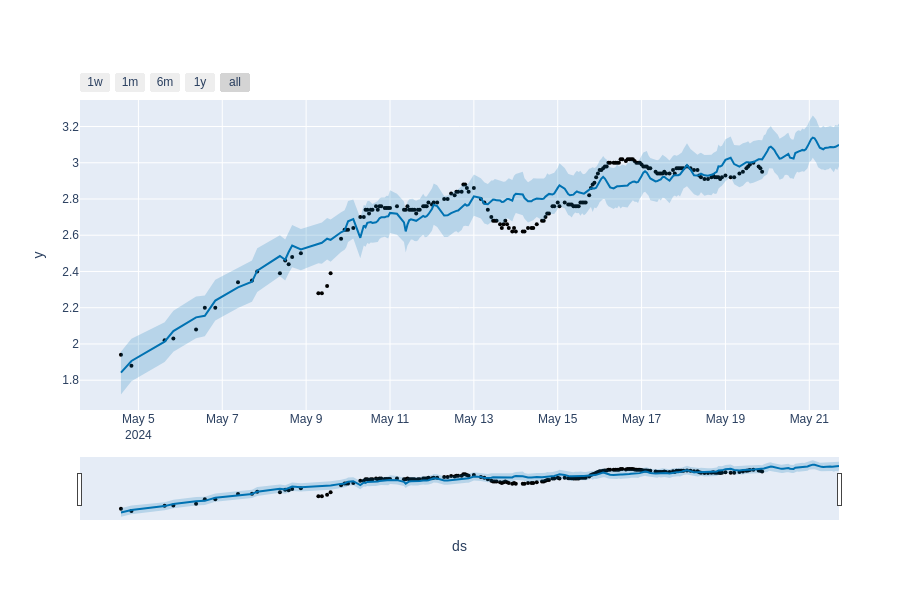

In [19]:
m = Prophet(
    yearly_seasonality=False,  
    weekly_seasonality=False,  
    daily_seasonality=True,    
    changepoint_range=0.8,     
    changepoint_prior_scale=0.9,
    changepoints=['2024-05-09 04:00:00'],
    growth="linear"         
)

# Defina os pontos de mudança
m.add_seasonality(name='daily', period=1, fourier_order=1, prior_scale = 0.01)
m.add_regressor("pos_wind", mode = "multiplicative", prior_scale = 0.8)

# Ajuste o modelo
m.fit(sao_goncalo_data)

# Realize previsões
future = m.make_future_dataframe(periods=44, freq='h')  

future['pos_wind'] = pos_wind['pos_wind']

forecast = m.predict(future)

# Visualize o resultado do modelo
plot_plotly(m, forecast)

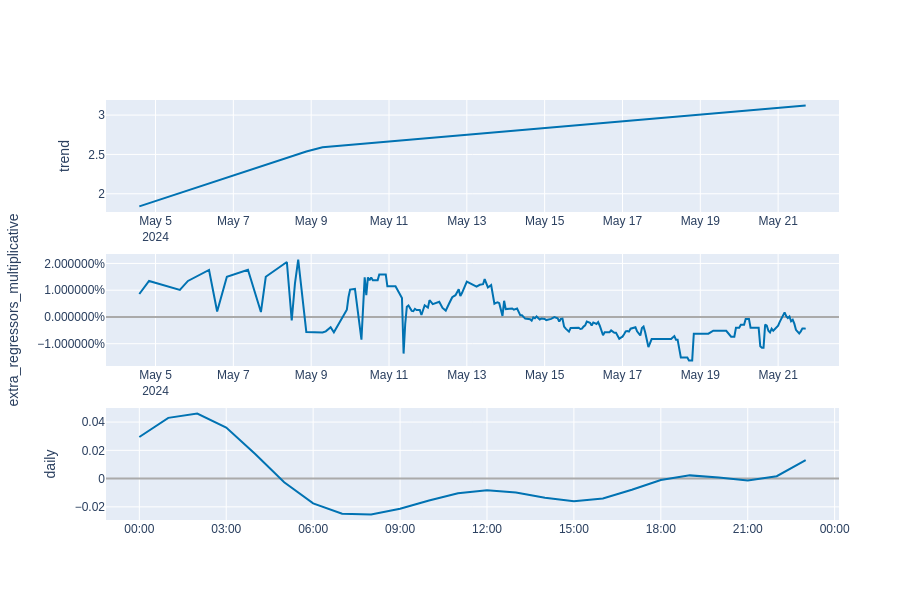

In [20]:
plot_components_plotly(m, forecast)

In [ ]:
df_cv = cross_validation(m, initial='2 hour', period='15 hour', horizon = '6 hour')
df_cv.head()

Seasonality has period of 1 days which is larger than initial window. Consider increasing initial.


  0%|          | 0/21 [00:00<?, ?it/s]

22:08:10 - cmdstanpy - INFO - Chain [1] start processing
22:08:12 - cmdstanpy - INFO - Chain [1] done processing
22:08:12 - cmdstanpy - INFO - Chain [1] start processing
22:08:16 - cmdstanpy - INFO - Chain [1] done processing
22:08:16 - cmdstanpy - INFO - Chain [1] start processing
22:08:16 - cmdstanpy - INFO - Chain [1] done processing
22:08:16 - cmdstanpy - INFO - Chain [1] start processing
22:08:16 - cmdstanpy - INFO - Chain [1] done processing
22:08:16 - cmdstanpy - INFO - Chain [1] start processing
22:08:16 - cmdstanpy - INFO - Chain [1] done processing
22:08:16 - cmdstanpy - INFO - Chain [1] start processing
22:08:16 - cmdstanpy - INFO - Chain [1] done processing
22:08:17 - cmdstanpy - INFO - Chain [1] start processing
22:08:17 - cmdstanpy - INFO - Chain [1] done processing
22:08:17 - cmdstanpy - INFO - Chain [1] start processing
22:08:17 - cmdstanpy - INFO - Chain [1] done processing
22:08:17 - cmdstanpy - INFO - Chain [1] start processing
22:08:17 - cmdstanpy - INFO - Chain [1]

In [ ]:
df_p = performance_metrics(df_cv)
df_p.head()

In [ ]:
fig = plot_cross_validation_metric(df_cv, metric='rmse')

In [ ]:
with open('data/serialized_model.json', 'w') as fout:
    fout.write(model_to_json(m))